In [1]:
# Imports
#%matplotlib QtAgg
from scipy.signal import *
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import *
import numpy as np

In [2]:
# Arguments
filename = 'ADC_capture_2024-10-23_11-27-17_CH_12.bin'
dataType = 'int16'
samplerate = 48000000
nfft = 10000000
IF = 10000000
Z = 100

In [3]:
# Loading Data
adcSamples=fromfile(filename, dtype=dataType)
N = len(adcSamples)
t = arange(N)/samplerate

In [4]:
def calcNbits(sig) :
    # AR: We consider the range of a n bit signed signal as -(2**(n-1)-1) to 2**(n-1)-1 for the analysis,
    # dispite the fact the 2's compliment representation allows -2**(n-1).
    #return ceil(log2(max((max(sig),-min(sig)))))+1
    return ceil(log2(max(max(sig),-min(sig))+1))+1
    
def printSigChacteristics(sig, sig_name: str) :
        print(f"{sig_name} Characteristics:")
        print(f"\tMax value:{max(sig)}")
        print(f"\tMin value:{min(sig)}")
        print(f"\tEffective number of bits: {calcNbits(sig)}")
        print(f"\tStd dev: {std(sig):.1f}")

def testSaturation(data, nbits) :
    #return any((np.array(data)<=-2**(nbits-1)) + (np.array(data)>=2**(nbits-1)-1))
    return any((np.array(data)<=-2**(nbits-1)) + (np.array(data)>=2**(nbits-1)))

def comparisonNoiseFloorDensity(ps, faxis, f_noise_low, f_noise_high):
    f_noise_mask2 = (faxis >= f_noise_low) * (faxis < f_noise_high)
    # AR: (f_noise_high - f_noise_low) does not accurately represent the actual frequency band that we accumulated the power spectral.
    # AR: The sum of power spectrul should be multiplied by rbw if we use frequency range in the denominator.
    #noise_power2 = sum(f_noise_mask2 * ps) / (f_noise_high - f_noise_low)
    noise_power2 = sum(f_noise_mask2 * ps) / sum(f_noise_mask2)
    print(f"Comparison noise power density ({round(f_noise_low/1e6, 2)} MHz-{round(f_noise_high/1e6, 2)} MHz): {round(10*log10(noise_power2),2)} dBW/Hz")

def calcOptimalFracBitCount(N, sig):
    return N - int(ceil(log2(max(-np.min(sig), np.max(sig))+2**(-N)))) - 1

def plotPSD(x, NFFT, Fs, fundFreqInterested, label: str):
    plt.figure()
    ps, faxis = plt.psd(x, NFFT, Fs)
    plt.ylabel('Power Spectral Density (dBW/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.title('PSD: ' + label)
    plt.show()

    rbw = Fs/NFFT
    print("{0} PSD RBW: {1} Hz".format(label, rbw))
    peakIndices, _ = find_peaks(ps)
    prominences = peak_prominences(ps, peakIndices)[0]
    maxProminenceIndices = argpartition(prominences, range(-6, -1))[-1:-6:-1]
    maxPeakIndices = peakIndices[maxProminenceIndices]
    maxPeakWidths = peak_widths(ps, maxPeakIndices, rel_height=0.9999)
    
    print("{} PSD Peaks:".format(label))
    for i in range(len(maxPeakIndices)):
        peakFreq = faxis[maxPeakIndices[i]]
        peakPower = ps[maxPeakIndices[i]]
        print("\tf{0} {1} MHz PeakPower: {2} dBW ({3} dBm)".format(i, round(peakFreq/1e6,2), round(10*log10(peakPower),2), round(10*log10(peakPower*1000),2)))

    print("{} PSD Bands:".format(label))
    for i in range(len(maxPeakIndices)):
        peakFreq = faxis[maxPeakIndices[i]]
        bandWidth = maxPeakWidths[0][i] * rbw
        bandPower = sum(ps[int(maxPeakWidths[2][i]):int(maxPeakWidths[3][i])]) * rbw
        print("\tf{0} {1} MHz BandPower: {2} dBW ({3} dBm), BandWidth: {4} Hz".format(i, round(peakFreq/1e6,2), round(10*log10(bandPower),2), round(10*log10(bandPower*1000),2), round(bandWidth,2)))

    noiseFloor = np.percentile(ps, 99.99)
    psNoise = np.where(ps<noiseFloor, ps, 0)
    
    No_rms = sum(psNoise)/len(psNoise)
    print('Noise floor density (rms), No: {0} dBW/Hz ({1} dBm/Hz)'.format(round(10*log10(No_rms),2), round(10*log10(No_rms*1000),2)))

    pNoise = sum(psNoise)*rbw
    print('Noise Power, pNoise: {0} dBW ({1} dBm)'.format(round(10*log10(pNoise),2), round(10*log10(pNoise*1000),2)))

    fundFreqIndices = np.where((faxis[maxPeakIndices] >= fundFreqInterested - 1e4) & (faxis[maxPeakIndices] <= fundFreqInterested + 1e4))
    if len(fundFreqIndices[0])==0:
        print('Fundamental frequency not detected.')
    else:
        fundFreqIndex = fundFreqIndices[0][0]
        fundFreq = faxis[maxPeakIndices[fundFreqIndex]]
        pFund = sum(ps[int(maxPeakWidths[2][fundFreqIndex]):int(maxPeakWidths[3][fundFreqIndex])]) * rbw
        print('Fundamental frequency detected: {0} MHz, Bandpower: {1} dBW ({2} dBm)'.format(round(fundFreq/1e6, 2), round(10*log10(pFund), 2), round(10*log10(pFund*1000), 2)))

        CNo = pFund/No_rms
        print('Carrier to Noise ratio, C/No: {} dBHz'.format(round(10*log10(CNo),2)))
    
        SNR = pFund/pNoise
        print('Signal to Noise ratio, SNR: {} dB'.format(round(10*log10(SNR),2)))

    return ps, faxis

adcSamples Characteristics:
	Max value:267
	Min value:-306
	Effective number of bits: 10.0
	Std dev: 16.1


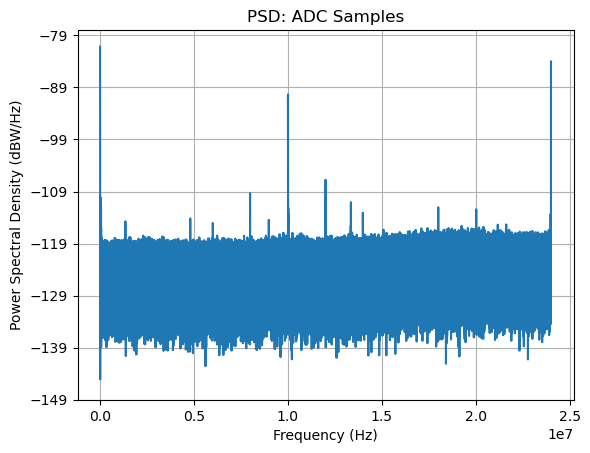

ADC Samples PSD RBW: 4.8 Hz
ADC Samples PSD Peaks:
	f0 10.0 MHz PeakPower: -90.36 dBW (-60.36 dBm)
	f1 12.0 MHz PeakPower: -106.76 dBW (-76.76 dBm)
	f2 12.0 MHz PeakPower: -108.66 dBW (-78.66 dBm)
	f3 7.98 MHz PeakPower: -109.29 dBW (-79.29 dBm)
	f4 0.02 MHz PeakPower: -110.07 dBW (-80.07 dBm)
ADC Samples PSD Bands:
	f0 10.0 MHz BandPower: -79.51 dBW (-49.51 dBm), BandWidth: 2623.8 Hz
	f1 12.0 MHz BandPower: -60.46 dBW (-30.46 dBm), BandWidth: 2375711.93 Hz
	f2 12.0 MHz BandPower: -88.9 dBW (-58.9 dBm), BandWidth: 2932.11 Hz
	f3 7.98 MHz BandPower: -59.66 dBW (-29.66 dBm), BandWidth: 3040795.15 Hz
	f4 0.02 MHz BandPower: -57.13 dBW (-27.13 dBm), BandWidth: 5604225.15 Hz
Noise floor density (rms), No: -123.86 dBW/Hz (-93.86 dBm/Hz)
Noise Power, pNoise: -50.06 dBW (-20.06 dBm)
Fundamental frequency detected: 10.0 MHz, Bandpower: -79.51 dBW (-49.51 dBm)
Carrier to Noise ratio, C/No: 44.35 dBHz
Signal to Noise ratio, SNR: -29.45 dB
Comparison noise power density (10.5 MHz-11.0 MHz): -124.2

In [5]:
# ADC Samples

printSigChacteristics(adcSamples, "adcSamples")
assert not testSaturation(adcSamples, 10)

# ADC samples are scaled by 512. -1V to 1V input range is scaled to -511 to 511.
# Furthermore, ADC Samples should be divided by sqrt(Z) to get the absolute power levels from the PSD. 
adc_scale_factor = log2(512) + log2(sqrt(Z))

# Plot PSD
ps, faxis = plotPSD(adcSamples/(2**adc_scale_factor), nfft, samplerate, IF, "ADC Samples")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 10.5e6, 11.0e6)

IQ_mod_I - before quantization Characteristics:
	Max value:7596000
	Min value:-8450550
	Effective number of bits: 25.0
	Std dev: 374216.0
IQ_mod_Q - before quantization Characteristics:
	Max value:8683362
	Min value:-6330000
	Effective number of bits: 25.0
	Std dev: 374278.0
IQ_mod_I_16b - after quantization Characteristics:
	Max value:14836
	Min value:-16505
	Effective number of bits: 16.0
	Std dev: 730.9
IQ_mod_Q_16b - after quantization Characteristics:
	Max value:16960
	Min value:-12363
	Effective number of bits: 16.0
	Std dev: 731.0


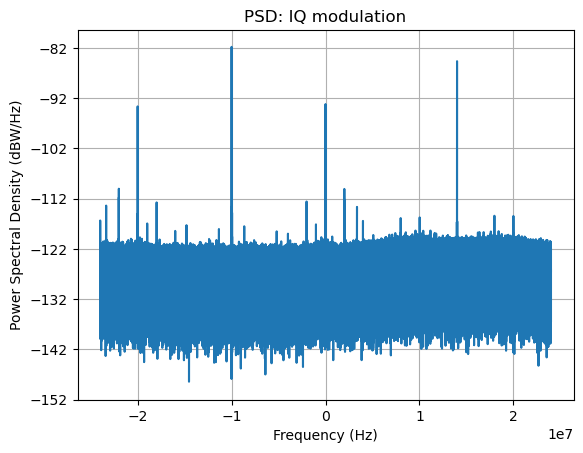

IQ modulation PSD RBW: 4.8 Hz
IQ modulation PSD Peaks:
	f0 -10.0 MHz PeakPower: -81.81 dBW (-51.81 dBm)
	f1 14.0 MHz PeakPower: -84.67 dBW (-54.67 dBm)
	f2 0.0 MHz PeakPower: -93.19 dBW (-63.19 dBm)
	f3 -20.0 MHz PeakPower: -93.66 dBW (-63.66 dBm)
	f4 -22.0 MHz PeakPower: -110.03 dBW (-80.03 dBm)
IQ modulation PSD Bands:
	f0 -10.0 MHz BandPower: -72.61 dBW (-42.61 dBm), BandWidth: 32.85 Hz
	f1 14.0 MHz BandPower: -75.47 dBW (-45.47 dBm), BandWidth: 140.53 Hz
	f2 0.0 MHz BandPower: -82.52 dBW (-52.52 dBm), BandWidth: 2624.16 Hz
	f3 -20.0 MHz BandPower: -81.09 dBW (-51.09 dBm), BandWidth: 9348.69 Hz
	f4 -22.0 MHz BandPower: -65.46 dBW (-35.46 dBm), BandWidth: 1466380.69 Hz
Noise floor density (rms), No: -126.87 dBW/Hz (-96.87 dBm/Hz)
Noise Power, pNoise: -50.06 dBW (-20.06 dBm)
Fundamental frequency detected: 0.0 MHz, Bandpower: -82.52 dBW (-52.52 dBm)
Carrier to Noise ratio, C/No: 44.35 dBHz
Signal to Noise ratio, SNR: -32.46 dB
Comparison noise power density (0.5 MHz-1.0 MHz): -127.24 

In [6]:
# IQ modulation

# 16 bit numerically generated complex sinusoid.
NLO_scale_factor = 15
NLO_I = np.int16(real(exp(-2*pi*IF*t*1j))*(2**15-1))
NLO_Q = np.int16(imag(exp(-2*pi*IF*t*1j))*(2**15-1))

# 10 bit * 16 bit signed-signed multiplication. 
# Multiplication output is considered 25 bit signed, noting that -512*(-32768) multiplication shall never occur.
IQ_mod_I = np.int32(adcSamples) * NLO_I
IQ_mod_Q = np.int32(adcSamples) * NLO_Q

printSigChacteristics(IQ_mod_I, "IQ_mod_I - before quantization")
printSigChacteristics(IQ_mod_Q, "IQ_mod_Q - before quantization")

# 25 bit multiplication output is quantized and rounded off to 16 bit signed.
IQ_mod_I_16_b = np.int16(np.round(IQ_mod_I/(2**9)))
IQ_mod_Q_16_b = np.int16(np.round(IQ_mod_Q/(2**9)))
printSigChacteristics(IQ_mod_I_16_b, "IQ_mod_I_16b - after quantization")
printSigChacteristics(IQ_mod_Q_16_b, "IQ_mod_Q_16b - after quantization")
assert not testSaturation(IQ_mod_I_16_b, 16)
assert not testSaturation(IQ_mod_Q_16_b, 16)

# Plot PSD
iq_mod_scale_factor = adc_scale_factor + NLO_scale_factor - 9
ps, faxis = plotPSD(IQ_mod_I_16_b/(2**iq_mod_scale_factor) + IQ_mod_Q_16_b*1j/(2**iq_mod_scale_factor), nfft, samplerate, 0, "IQ modulation")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 0.5e6, 1.0e6)

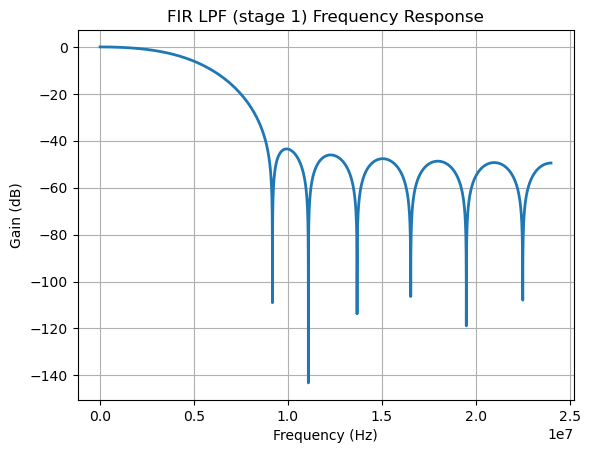

FIR LPF (stage 1) filter taps: -0.006578285785536713, -0.010530284961632618, -0.0036316007629663247, 0.02387639502178807, 0.07375879147478327, 0.1347704508620579, 0.1856131597365274, 0.20544274882995825, 0.1856131597365274, 0.1347704508620579, 0.07375879147478327, 0.02387639502178807, -0.0036316007629663247, -0.010530284961632618, -0.006578285785536713
FIR LPF (stage 1) filter taps (scaled) Characteristics:
	Max value:55148117
	Min value:-2826701
	Effective number of bits: 27.0
	Std dev: 21150973.6
	Filter order: 15
	Fractioanl bit count: {fracBitCount}
FIR_LPF_stage_1_I - before quantization Characteristics:
	Max value:1443992792720.0
	Min value:-1092217787654.0
	Effective number of bits: 42.0
	Std dev: 75201903756.8
FIR_LPF_stage_1_Q - before quantization Characteristics:
	Max value:1043452652777.0
	Min value:-890889645864.0
	Effective number of bits: 41.0
	Std dev: 75189564253.1
LPF_stage_1_I_16b - after quantization Characteristics:
	Max value:10759
	Min value:-8138
	Effective numb

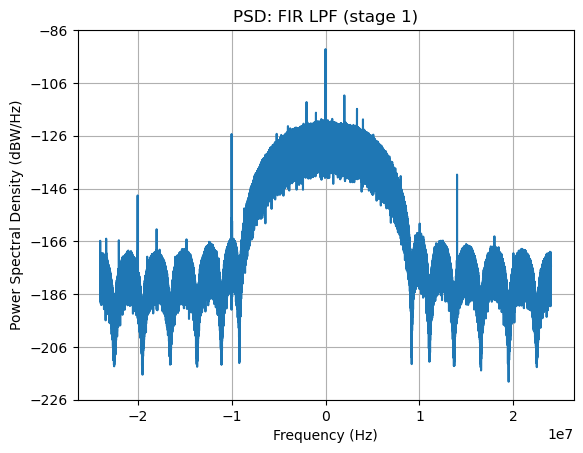

FIR LPF (stage 1) PSD RBW: 4.8 Hz
FIR LPF (stage 1) PSD Peaks:
	f0 0.0 MHz PeakPower: -93.19 dBW (-63.19 dBm)
	f1 2.0 MHz PeakPower: -110.73 dBW (-80.73 dBm)
	f2 2.0 MHz PeakPower: -112.81 dBW (-82.81 dBm)
	f3 -2.02 MHz PeakPower: -113.24 dBW (-83.24 dBm)
	f4 0.02 MHz PeakPower: -114.8 dBW (-84.8 dBm)
FIR LPF (stage 1) PSD Bands:
	f0 0.0 MHz BandPower: -82.52 dBW (-52.52 dBm), BandWidth: 2624.55 Hz
	f1 2.0 MHz BandPower: -65.16 dBW (-35.16 dBm), BandWidth: 1816881.52 Hz
	f2 2.0 MHz BandPower: -84.82 dBW (-54.82 dBm), BandWidth: 19814.22 Hz
	f3 -2.02 MHz BandPower: -64.87 dBW (-34.87 dBm), BandWidth: 1969723.07 Hz
	f4 0.02 MHz BandPower: -81.16 dBW (-51.16 dBm), BandWidth: 12167.87 Hz
Noise floor density (rms), No: -135.24 dBW/Hz (-105.24 dBm/Hz)
Noise Power, pNoise: -58.43 dBW (-28.43 dBm)
Fundamental frequency detected: 0.0 MHz, Bandpower: -82.52 dBW (-52.52 dBm)
Carrier to Noise ratio, C/No: 52.72 dBHz
Signal to Noise ratio, SNR: -24.1 dB
Comparison noise power density (0.5 MHz-1.0 M

In [7]:
# FIR LPF (Stage 1)

# Calculate FIR filter coefficients
nyq_rate = samplerate//2
cutoff_hz = 5E6
width = 8.0E6/nyq_rate
ripple_db = 40.0
N_LPF, beta = kaiserord(ripple_db, width)
taps = firwin(N_LPF, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Plot frequency response
plt.figure()
w, h = freqz(taps, worN=8000)
plt.plot((w/pi)*nyq_rate, 20*log10(absolute(h)), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('FIR LPF (stage 1) Frequency Response')
plt.grid(True)
plt.show()

# print("LPF filter coef")
print("FIR LPF (stage 1) filter taps: " + ', '.join(taps.astype(str)))

# Xilinx FIR comiler IP optimally selects the fractional bit count given the coef bit width and the filter coefficients. 
# 27 bits are used for the coefficients.
fracBitCount = calcOptimalFracBitCount(27, taps)
scaledTaps = np.int32(taps * float(2**fracBitCount))
printSigChacteristics(scaledTaps, "FIR LPF (stage 1) filter taps (scaled)")
assert not testSaturation(scaledTaps, 27)
print(f"\tFilter order: {len(scaledTaps)}")
print("\tFractioanl bit count: {fracBitCount}")

# Apply filter
LPF_stage_1_I = lfilter(scaledTaps, 1.0, IQ_mod_I_16_b)
LPF_stage_1_Q = lfilter(scaledTaps, 1.0, IQ_mod_Q_16_b)
printSigChacteristics(LPF_stage_1_I, "FIR_LPF_stage_1_I - before quantization")
printSigChacteristics(LPF_stage_1_Q, "FIR_LPF_stage_1_Q - before quantization")

# Quantize output to 16 bits.
# The f_0 + f_if component which generated by IQ modulation, is filtered out by the LPF, Hence the signal power is attenuated by half
# Therefore, we can make use of an additional fraction bit. (fracBitCount-1) is used for the quantization.
LPF_stage_1_I_16b = np.int16(np.round(LPF_stage_1_I / 2**(fracBitCount-1)))
LPF_stage_1_Q_16b = np.int16(np.round(LPF_stage_1_Q / 2**(fracBitCount-1)))
printSigChacteristics(LPF_stage_1_I_16b, "LPF_stage_1_I_16b - after quantization")
printSigChacteristics(LPF_stage_1_Q_16b, "LPF_stage_1_Q_16b - after quantization")
assert not testSaturation(LPF_stage_1_I_16b, 16)
assert not testSaturation(LPF_stage_1_Q_16b, 16)

# Plot PSD
lpf_stage_1_scale_factor = iq_mod_scale_factor + 1
ps, faxis = plotPSD(LPF_stage_1_I_16b/(2**lpf_stage_1_scale_factor) + LPF_stage_1_Q_16b*1j/(2**lpf_stage_1_scale_factor), nfft, samplerate, 0, "FIR LPF (stage 1)")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 0.5e6, 1.0e6)

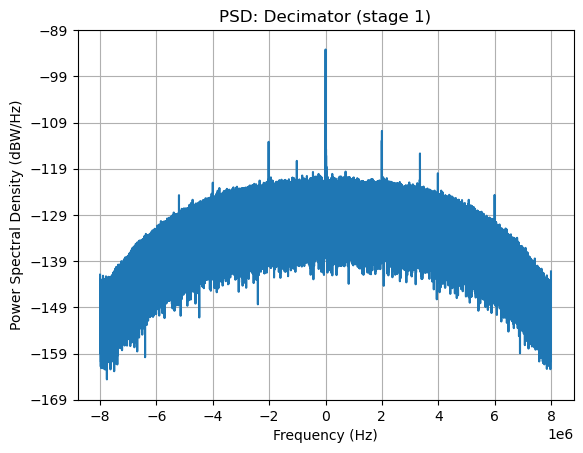

Decimator (stage 1) PSD RBW: 4.800000480000048 Hz
Decimator (stage 1) PSD Peaks:
	f0 0.0 MHz PeakPower: -93.19 dBW (-63.19 dBm)
	f1 2.0 MHz PeakPower: -110.82 dBW (-80.82 dBm)
	f2 2.0 MHz PeakPower: -112.9 dBW (-82.9 dBm)
	f3 -2.02 MHz PeakPower: -113.18 dBW (-83.18 dBm)
	f4 0.02 MHz PeakPower: -114.8 dBW (-84.8 dBm)
Decimator (stage 1) PSD Bands:
	f0 0.0 MHz BandPower: -82.52 dBW (-52.52 dBm), BandWidth: 2624.54 Hz
	f1 2.0 MHz BandPower: -66.64 dBW (-36.64 dBm), BandWidth: 1242609.61 Hz
	f2 2.0 MHz BandPower: -84.82 dBW (-54.82 dBm), BandWidth: 19814.3 Hz
	f3 -2.02 MHz BandPower: -70.74 dBW (-40.74 dBm), BandWidth: 573527.9 Hz
	f4 0.02 MHz BandPower: -81.16 dBW (-51.16 dBm), BandWidth: 12167.87 Hz
Noise floor density (rms), No: -130.46 dBW/Hz (-100.46 dBm/Hz)
Noise Power, pNoise: -58.42 dBW (-28.42 dBm)
Fundamental frequency detected: 0.0 MHz, Bandpower: -82.52 dBW (-52.52 dBm)
Carrier to Noise ratio, C/No: 47.94 dBHz
Signal to Noise ratio, SNR: -24.1 dB
Comparison noise power density

In [8]:
# Decimation (Stage 1)

# Update parameters
decimate_ratio = 3
stage_1_decimator_samplerate = samplerate/decimate_ratio
stage_1_decimator_nfft = int(nfft/decimate_ratio)

# Decimation
stage_1_decimated_I = LPF_stage_1_I_16b[0::decimate_ratio]
stage_1_decimated_Q = LPF_stage_1_Q_16b[0::decimate_ratio]

# plot PSD
stage_1_decimator_scale_factor = lpf_stage_1_scale_factor
ps, faxis = plotPSD(stage_1_decimated_I/(2**stage_1_decimator_scale_factor) + stage_1_decimated_Q*1j/(2**stage_1_decimator_scale_factor), stage_1_decimator_nfft, stage_1_decimator_samplerate, 0, "Decimator (stage 1)")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 0.5e6, 1.0e6)

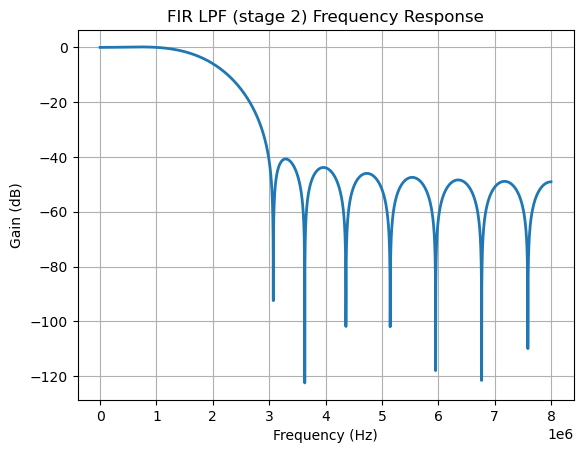

FIR LPF (stage 2) filter taps: 0.0037344801260532695, -2.4779015026214493e-18, -0.012036048507983139, -0.02668335120983079, -0.028464484314588263, 7.346366245083755e-18, 0.06444895712489258, 0.14965253704653808, 0.22319783366123067, 0.2523001521473751, 0.22319783366123067, 0.14965253704653808, 0.06444895712489258, 7.346366245083755e-18, -0.028464484314588263, -0.02668335120983079, -0.012036048507983139, -2.4779015026214493e-18, 0.0037344801260532695
FIR LPF (stage 2) filter taps (scaled) Characteristics:
	Max value:33863153
	Min value:-3820438
	Effective number of bits: 27.0
	Std dev: 12587708.0
	Filter order: 19
	Fractioanl bit count: {fracBitCount}
FIR_LPF_stage_2_I - before quantization Characteristics:
	Max value:808681382636.0
	Min value:-1059925525685.0
	Effective number of bits: 41.0
	Std dev: 50351743262.1
FIR_LPF_stage_2_Q - before quantization Characteristics:
	Max value:936201263624.0
	Min value:-835157796722.0
	Effective number of bits: 41.0
	Std dev: 50308229645.7
LPF_stag

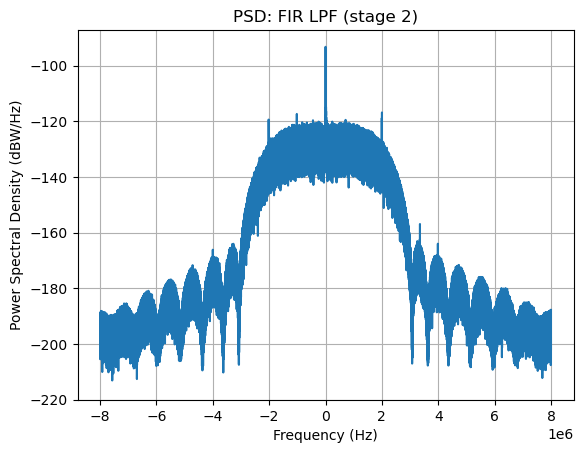

FIR LPF (stage 2) PSD RBW: 4.800000480000048 Hz
FIR LPF (stage 2) PSD Peaks:
	f0 0.0 MHz PeakPower: -93.19 dBW (-63.19 dBm)
	f1 0.02 MHz PeakPower: -114.8 dBW (-84.8 dBm)
	f2 0.02 MHz PeakPower: -115.2 dBW (-85.2 dBm)
	f3 0.02 MHz PeakPower: -115.23 dBW (-85.23 dBm)
	f4 0.02 MHz PeakPower: -115.23 dBW (-85.23 dBm)
FIR LPF (stage 2) PSD Bands:
	f0 0.0 MHz BandPower: -82.52 dBW (-52.52 dBm), BandWidth: 2624.54 Hz
	f1 0.02 MHz BandPower: -81.15 dBW (-51.15 dBm), BandWidth: 12167.87 Hz
	f2 0.02 MHz BandPower: -92.3 dBW (-62.3 dBm), BandWidth: 806.27 Hz
	f3 0.02 MHz BandPower: -92.02 dBW (-62.02 dBm), BandWidth: 757.83 Hz
	f4 0.02 MHz BandPower: -97.26 dBW (-67.26 dBm), BandWidth: 220.21 Hz
Noise floor density (rms), No: -134.01 dBW/Hz (-104.01 dBm/Hz)
Noise Power, pNoise: -61.97 dBW (-31.97 dBm)
Fundamental frequency detected: 0.0 MHz, Bandpower: -82.52 dBW (-52.52 dBm)
Carrier to Noise ratio, C/No: 51.49 dBHz
Signal to Noise ratio, SNR: -20.55 dB
Comparison noise power density (0.5 MHz-1.

In [9]:
# FIR LPF (Stage 2)

# Calculate FIR filter coefficients
nyq_rate = stage_1_decimator_samplerate//2
cutoff_hz = 2.0E6
width = 2.0E6/nyq_rate
ripple_db = 40.0
N_LPF, beta = kaiserord(ripple_db, width)
taps = firwin(N_LPF, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Plot freq response
w, h = freqz(taps, worN=8000)
plt.figure()
plt.plot((w/pi)*nyq_rate, 20*log10(absolute(h)), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.title('FIR LPF (stage 2) Frequency Response')
plt.grid(True)
plt.show()

# print("LPF filter coef")
print("FIR LPF (stage 2) filter taps: " + ', '.join(taps.astype(str)))

# Xilinx FIR comiler IP optimally selects the fractional bit count given the coef bit width and the filter coefficients. 
# 27 bits are used for the coefficients.
fracBitCount = calcOptimalFracBitCount(27, taps)
scaledTaps = np.int32(taps * float(2**fracBitCount))
printSigChacteristics(scaledTaps, "FIR LPF (stage 2) filter taps (scaled)")
assert not testSaturation(scaledTaps, 27)
print(f"\tFilter order: {len(scaledTaps)}")
print("\tFractioanl bit count: {fracBitCount}")

# Apply filter
LPF_stage_2_I = lfilter(scaledTaps, 1.0, stage_1_decimated_I)
LPF_stage_2_Q = lfilter(scaledTaps, 1.0, stage_1_decimated_Q)
printSigChacteristics(LPF_stage_2_I, "FIR_LPF_stage_2_I - before quantization")
printSigChacteristics(LPF_stage_2_Q, "FIR_LPF_stage_2_Q - before quantization")

# Quantize output to 16 bits.
LPF_stage_2_I_16b = np.int16(np.round(LPF_stage_2_I / 2**fracBitCount))
LPF_stage_2_Q_16b = np.int16(np.round(LPF_stage_2_Q / 2**fracBitCount))
printSigChacteristics(LPF_stage_2_I_16b, "LPF_stage_2_I_16b - after quantization")
printSigChacteristics(LPF_stage_2_Q_16b, "LPF_stage_2_Q_16b - after quantization")
assert not testSaturation(LPF_stage_2_I_16b, 16)
assert not testSaturation(LPF_stage_2_Q_16b, 16)

# Plot PSD
lpf_stage_2_scale_factor = stage_1_decimator_scale_factor
ps, faxis = plotPSD(LPF_stage_2_I_16b/(2**lpf_stage_2_scale_factor) + LPF_stage_2_Q_16b*1j/(2**lpf_stage_2_scale_factor), stage_1_decimator_nfft, stage_1_decimator_samplerate, 0, "FIR LPF (stage 2)")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 0.5e6, 1.0e6)

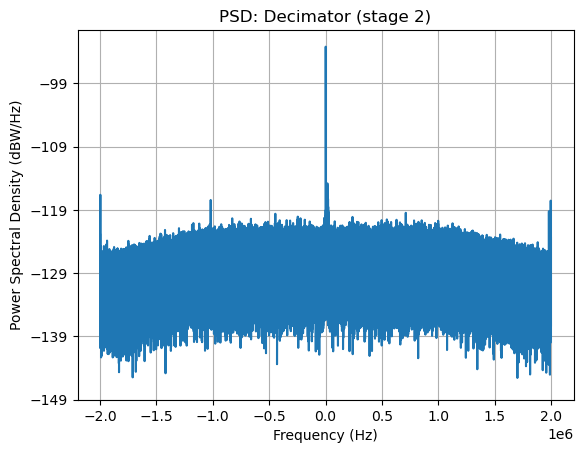

Decimator (stage 2) PSD RBW: 4.800001920000768 Hz
Decimator (stage 2) PSD Peaks:
	f0 0.0 MHz PeakPower: -93.19 dBW (-63.19 dBm)
	f1 0.02 MHz PeakPower: -114.8 dBW (-84.8 dBm)
	f2 0.02 MHz PeakPower: -115.21 dBW (-85.21 dBm)
	f3 0.02 MHz PeakPower: -115.23 dBW (-85.23 dBm)
	f4 0.02 MHz PeakPower: -115.23 dBW (-85.23 dBm)
Decimator (stage 2) PSD Bands:
	f0 0.0 MHz BandPower: -82.52 dBW (-52.52 dBm), BandWidth: 2624.3 Hz
	f1 0.02 MHz BandPower: -81.16 dBW (-51.16 dBm), BandWidth: 12167.87 Hz
	f2 0.02 MHz BandPower: -92.3 dBW (-62.3 dBm), BandWidth: 806.27 Hz
	f3 0.02 MHz BandPower: -92.02 dBW (-62.02 dBm), BandWidth: 757.83 Hz
	f4 0.02 MHz BandPower: -97.26 dBW (-67.26 dBm), BandWidth: 220.19 Hz
Noise floor density (rms), No: -127.98 dBW/Hz (-97.98 dBm/Hz)
Noise Power, pNoise: -61.96 dBW (-31.96 dBm)
Fundamental frequency detected: 0.0 MHz, Bandpower: -82.52 dBW (-52.52 dBm)
Carrier to Noise ratio, C/No: 45.46 dBHz
Signal to Noise ratio, SNR: -20.56 dB
Comparison noise power density (0.5 

In [10]:
# Decimation (Stage 2)

# Update parameters
decimate_ratio = 4
stage_2_decimator_samplerate = stage_1_decimator_samplerate/decimate_ratio
stage_2_decimator_nfft = int(stage_1_decimator_nfft/decimate_ratio)

# Decimation
stage_2_decimated_I = LPF_stage_2_I_16b[0::decimate_ratio]
stage_2_decimated_Q = LPF_stage_2_Q_16b[0::decimate_ratio]

# plot PSD
stage_2_decimator_scale_factor = lpf_stage_2_scale_factor
ps, faxis = plotPSD(stage_2_decimated_I/(2**stage_2_decimator_scale_factor) + stage_2_decimated_Q*1j/(2**stage_2_decimator_scale_factor), stage_2_decimator_nfft, stage_2_decimator_samplerate, 0, "Decimator (stage 2)")

# MF Noise floor calculation
comparisonNoiseFloorDensity(ps, faxis, 0.5e6, 1.0e6)